In [15]:
# Import required libraries
import os
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [16]:
# Paths for images
benign_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign'
malignant_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant'
normal_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal'

# List of image filenames
benign_images = os.listdir(benign_path)
malignant_images = os.listdir(malignant_path)
normal_images = os.listdir(normal_path)

# Merge all images
images = benign_images + malignant_images + normal_images


In [17]:
def find_mask(path):
    """Return mask filename corresponding to an image."""
    return path[:-4] + '_mask' + path[-4:]


In [18]:
def load_data(image_dir: str, images: list, image_shape: tuple = (256, 256)):
    """
    Load images and masks as numpy arrays with resizing for efficiency.
    """
    images_list = []
    masks_list = []

    for image in images:
        if 'mask' not in image:
            try:
                typ = image.split(' ')[0]
                img = cv2.imread(os.path.join(image_dir, typ, image))
                mask = cv2.imread(os.path.join(image_dir, typ, find_mask(image)), cv2.IMREAD_GRAYSCALE)
            except FileNotFoundError:
                continue

            # Resize images and masks
            img = cv2.resize(img, image_shape)
            mask = cv2.resize(mask, image_shape, interpolation=cv2.INTER_NEAREST)
            
            # Convert mask to single channel if needed
            if mask.ndim == 3:
                mask = mask[:, :, 0]

            images_list.append(img)
            masks_list.append(mask)

    images_array = np.array(images_list, dtype=np.float32) / 255.0  # Normalize images
    masks_array = np.array(masks_list, dtype=np.float32) / 255.0     # Normalize masks
    print(f"Loaded {images_array.shape[0]} images and {masks_array.shape[0]} masks.")
    return images_array, masks_array

# Load data
pro_images, pro_masks = load_data('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', images)


Loaded 780 images and 780 masks.


In [21]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(pro_images, pro_masks, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (624, 256, 256, 3) (624, 256, 256)
Test shape: (156, 256, 256, 3) (156, 256, 256)


In [23]:
def Convolution_block(input_tensor, num_filters, kernel_size=(3,3), use_batch_norm=True):
    x = Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if use_batch_norm:
        x = BatchNormalization()(x)
    x = Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    return x

def crop_concat(upsampled, skip):
    up_shape = K.int_shape(upsampled)
    skip_shape = K.int_shape(skip)
    height_diff = skip_shape[1] - up_shape[1]
    width_diff = skip_shape[2] - up_shape[2]
    if height_diff != 0 or width_diff != 0:
        skip = Cropping2D(((height_diff // 2, height_diff - height_diff // 2),
                           (width_diff // 2, width_diff - width_diff // 2)))(skip)
    return concatenate([upsampled, skip])


In [24]:
def Build_Unet(input_shape=(256,256,3), num_filters=16, dropout_rate=0.1, use_batch_norm=True):
    inputs = Input(input_shape)

    # Encoder
    c1 = Convolution_block(inputs, num_filters, use_batch_norm=use_batch_norm)
    p1 = MaxPool2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = Convolution_block(p1, num_filters*2, use_batch_norm=use_batch_norm)
    p2 = MaxPool2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = Convolution_block(p2, num_filters*4, use_batch_norm=use_batch_norm)
    p3 = MaxPool2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    c4 = Convolution_block(p3, num_filters*8, use_batch_norm=use_batch_norm)
    p4 = MaxPool2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = Convolution_block(p4, num_filters*16, use_batch_norm=use_batch_norm)

    # Decoder
    u6 = Conv2DTranspose(num_filters*8, (3,3), strides=(2,2), padding='same')(c5)
    u6 = crop_concat(u6, c4)
    u6 = Dropout(dropout_rate)(u6)
    c6 = Convolution_block(u6, num_filters*8, use_batch_norm=use_batch_norm)

    u7 = Conv2DTranspose(num_filters*4, (3,3), strides=(2,2), padding='same')(c6)
    u7 = crop_concat(u7, c3)
    u7 = Dropout(dropout_rate)(u7)
    c7 = Convolution_block(u7, num_filters*4, use_batch_norm=use_batch_norm)

    u8 = Conv2DTranspose(num_filters*2, (3,3), strides=(2,2), padding='same')(c7)
    u8 = crop_concat(u8, c2)
    u8 = Dropout(dropout_rate)(u8)
    c8 = Convolution_block(u8, num_filters*2, use_batch_norm=use_batch_norm)

    u9 = Conv2DTranspose(num_filters, (3,3), strides=(2,2), padding='same')(c8)
    u9 = crop_concat(u9, c1)
    u9 = Dropout(dropout_rate)(u9)
    c9 = Convolution_block(u9, num_filters, use_batch_norm=use_batch_norm)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Initialize model
input_shape = (256,256,3)
model = Build_Unet(input_shape)


In [25]:
# Define callbacks for efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_unet_model.h5', save_best_only=True, monitor='val_loss')

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [26]:
# ⚡ Super-fast test mode training (just to check pipeline)
history = model.fit(
    X_train[:100], y_train[:100],        # only 100 training images
    validation_data=(X_test[:20], y_test[:20]),   # only 20 validation images
    epochs=2,                            # only 2 epochs
    verbose=1,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 13s/step - accuracy: 0.5018 - loss: 0.8397 - val_accuracy: 0.5291 - val_loss: 7.0784 - learning_rate: 0.0010
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 12s/step - accuracy: 0.5142 - loss: 0.7078 - val_accuracy: 0.1194 - val_loss: 14.0164 - learning_rate: 0.0010


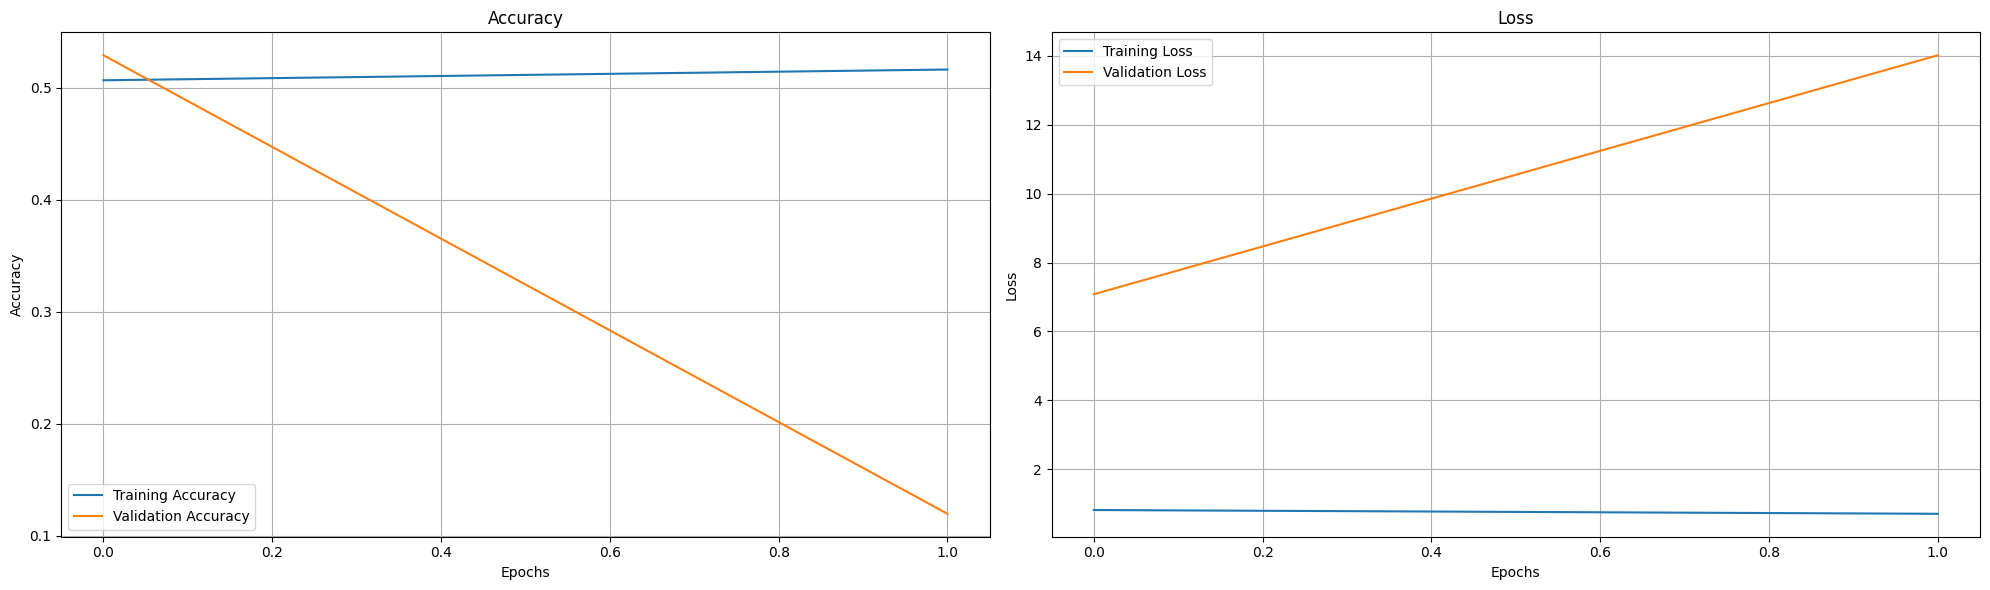

In [31]:
# Plot accuracy and loss
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('training_history.png')  # saves the chart automatically
plt.show()


In [32]:
def predict_mask(input_image):
    """
    Predict segmentation mask and measure inference time
    """
    start_time = time.time()
    pred_mask = model.predict(np.expand_dims(input_image, axis=0), verbose=0)[0,:,:,0]
    inference_time = time.time() - start_time
    return pred_mask, inference_time


In [36]:
def visualize_prediction(image, pred_mask, true_mask):
    """
    Display original image, predicted mask, and true mask side by side
    """
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1,3,2)
    plt.imshow(pred_mask)
    plt.title('Predicted Mask')

    plt.subplot(1,3,3)
    plt.imshow(true_mask)
    plt.title('True Mask')

    plt.tight_layout()
    plt.show()


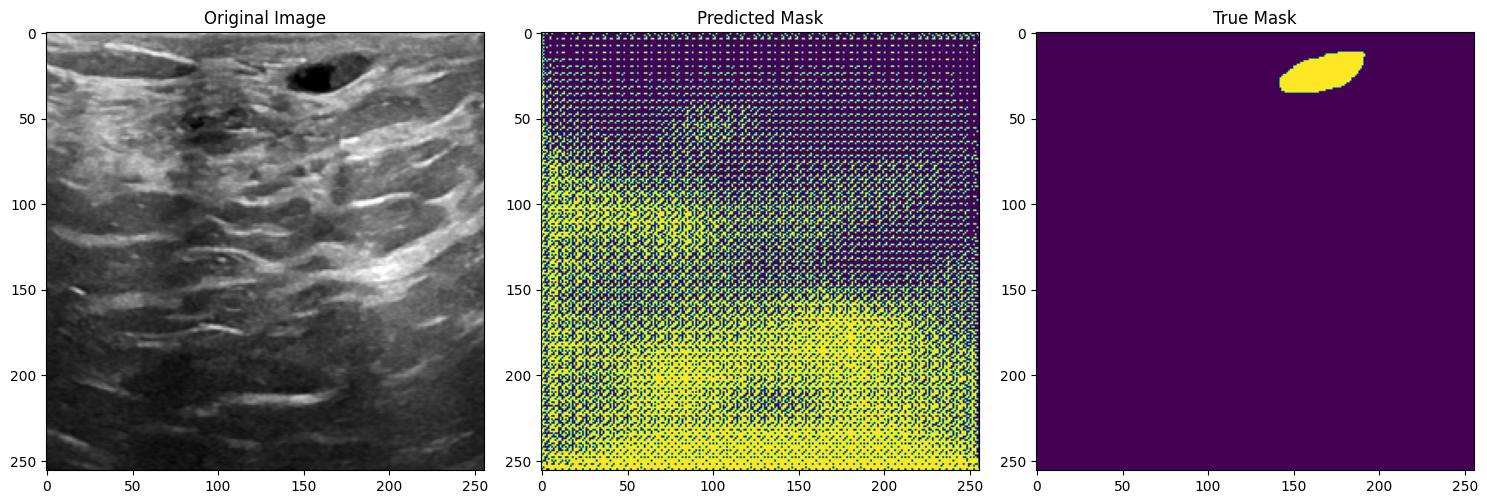

Inference time: 1.0706 seconds


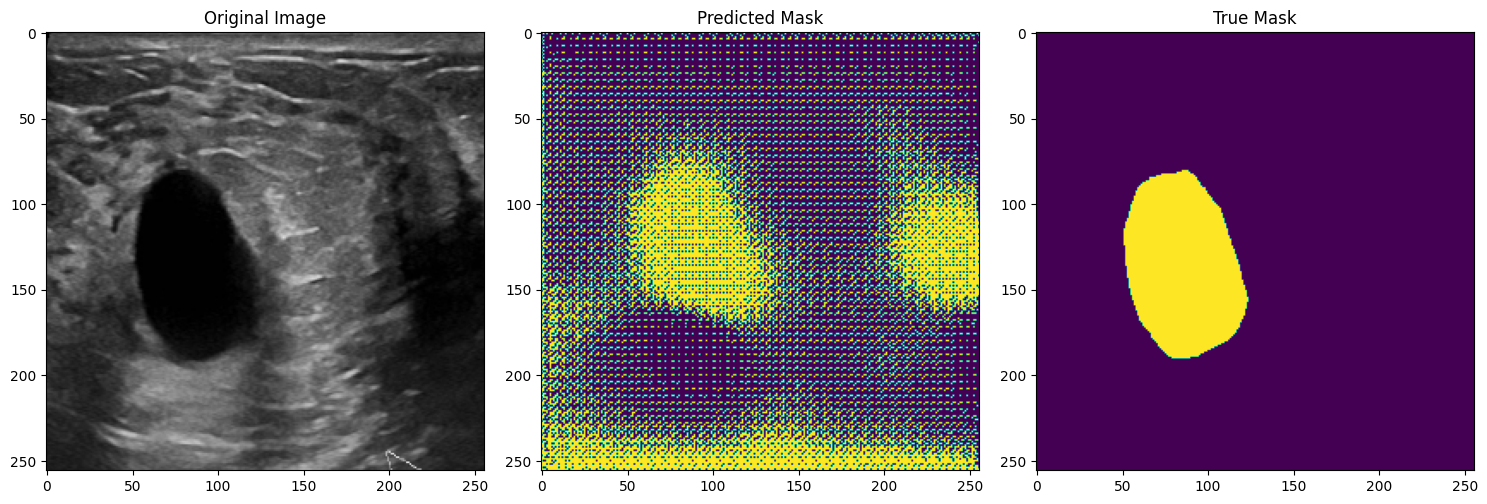

Inference time: 0.2217 seconds


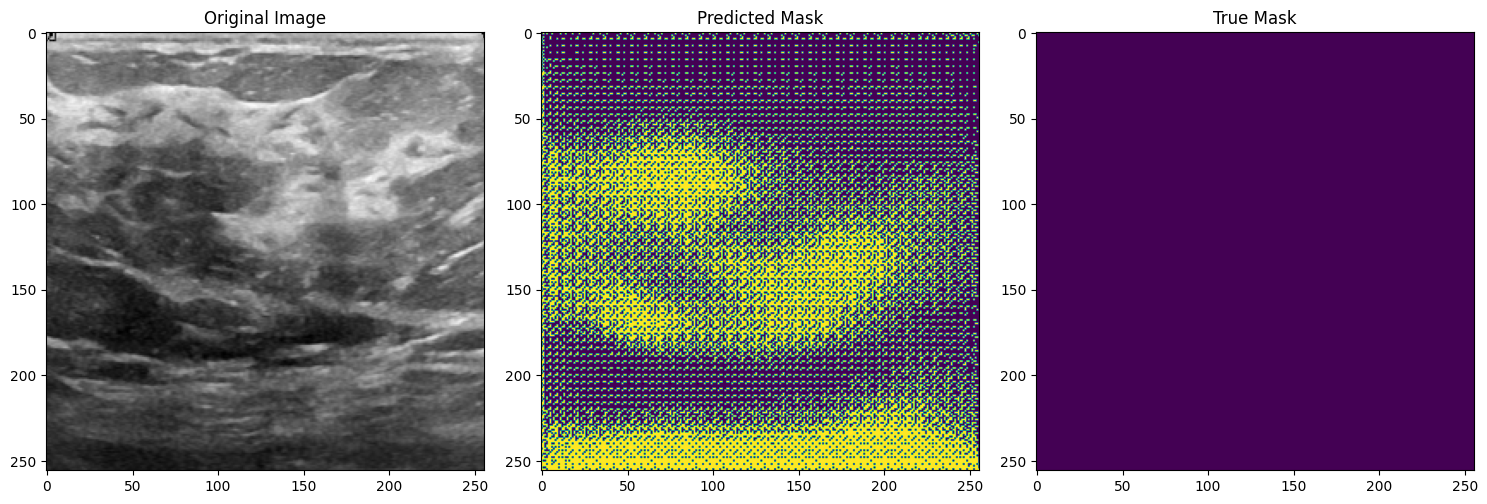

Inference time: 0.2133 seconds


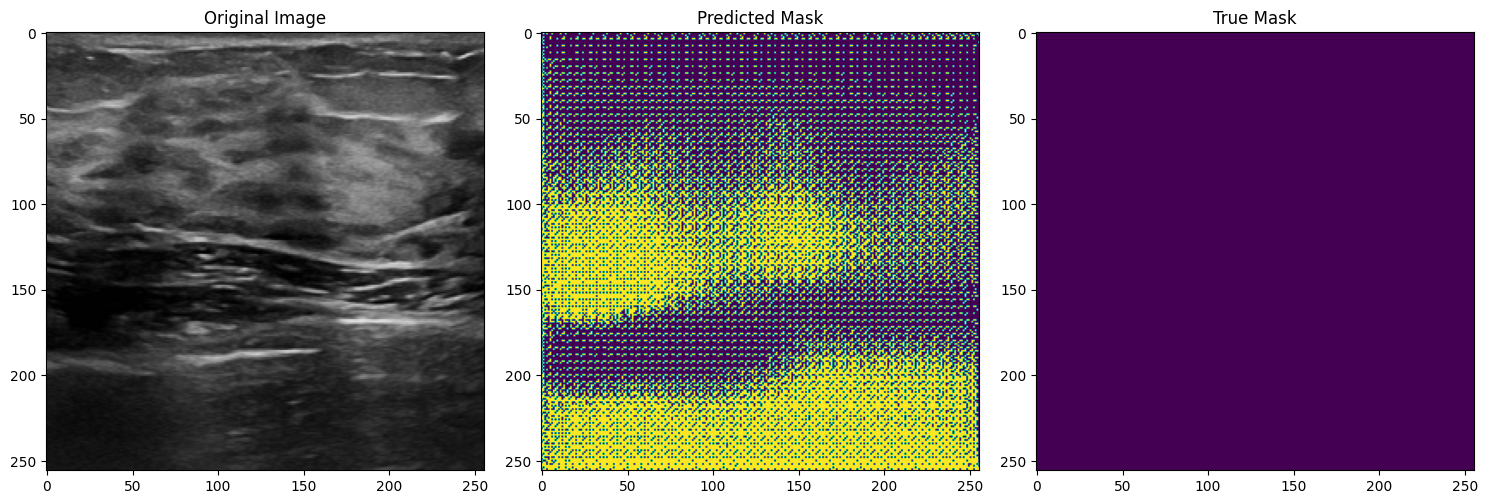

Inference time: 0.2049 seconds


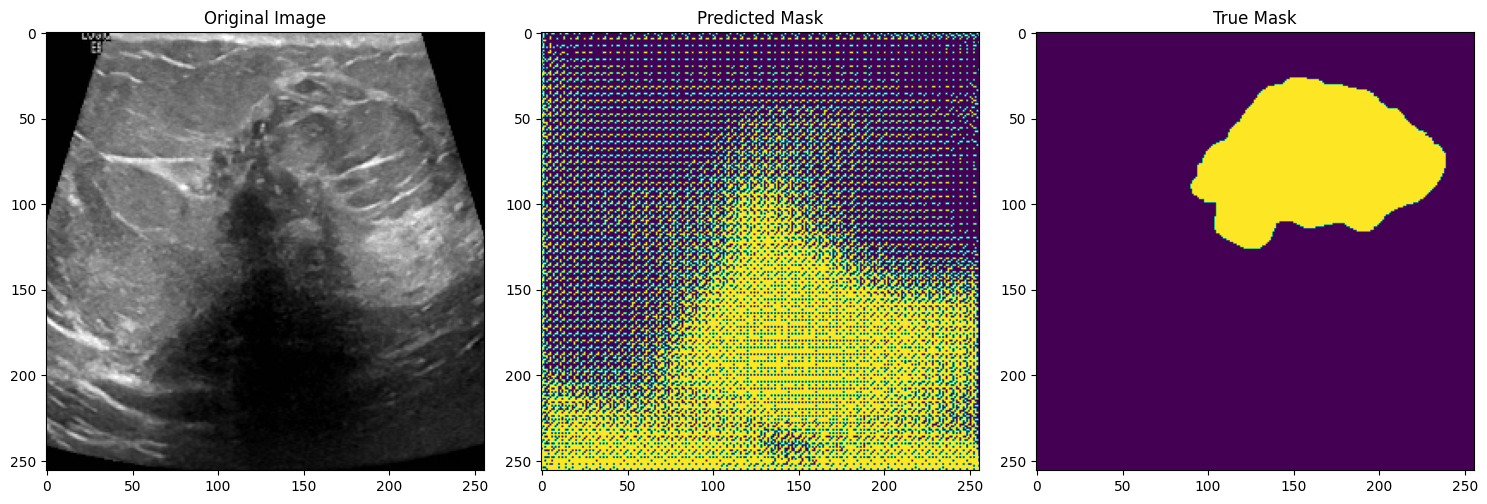

Inference time: 0.1958 seconds


In [35]:
def batch_predictions(X_test, y_test, num_samples=5):
    """
    Make predictions on a batch of test images for efficiency
    """
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    for idx in indices:
        img = X_test[idx]
        true_mask = y_test[idx]
        pred_mask, inference_time = predict_mask(img)
        binary_mask = (pred_mask > 0.5).astype(np.uint8)
        visualize_prediction(img, binary_mask, true_mask)
        print(f"Inference time: {inference_time:.4f} seconds")

# Run batch prediction
batch_predictions(X_test, y_test, num_samples=5)


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save best model during training
checkpoint = ModelCheckpoint("best_unet_model.h5", monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

# Train for a few epochs (you can increase later)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,   # small number for quick results
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


NameError: name 'X_train' is not defined